In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

## Data cleaning

In [19]:
import pandas as pd

# Just load the sheet directly as a DataFrame
df = pd.read_excel("SoilHealthDB_V2.xlsx", sheet_name='Sheet1')

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Rename for clarity and consistency (only those that exist)
rename_map = {
    'CoverCropGroup': 'CoverCropGroup',
    'Tillage_Top_T': 'Tillage',
    'Rotation_Top_T': 'Rotation',
    'GrainCropGroup': 'GrainCropGroup',
    'Grazing_Top_T': 'Grazing',
    'SoilBD': 'SoilBD'
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# Keep only relevant columns that are present
needed_columns = ['CoverCropGroup', 'Tillage', 'Rotation', 'GrainCropGroup', 'Grazing', 'SoilBD']
df = df[[col for col in needed_columns if col in df.columns]]

# Drop rows where SoilBD is missing
df = df.dropna(subset=['SoilBD'])


## Data exploration

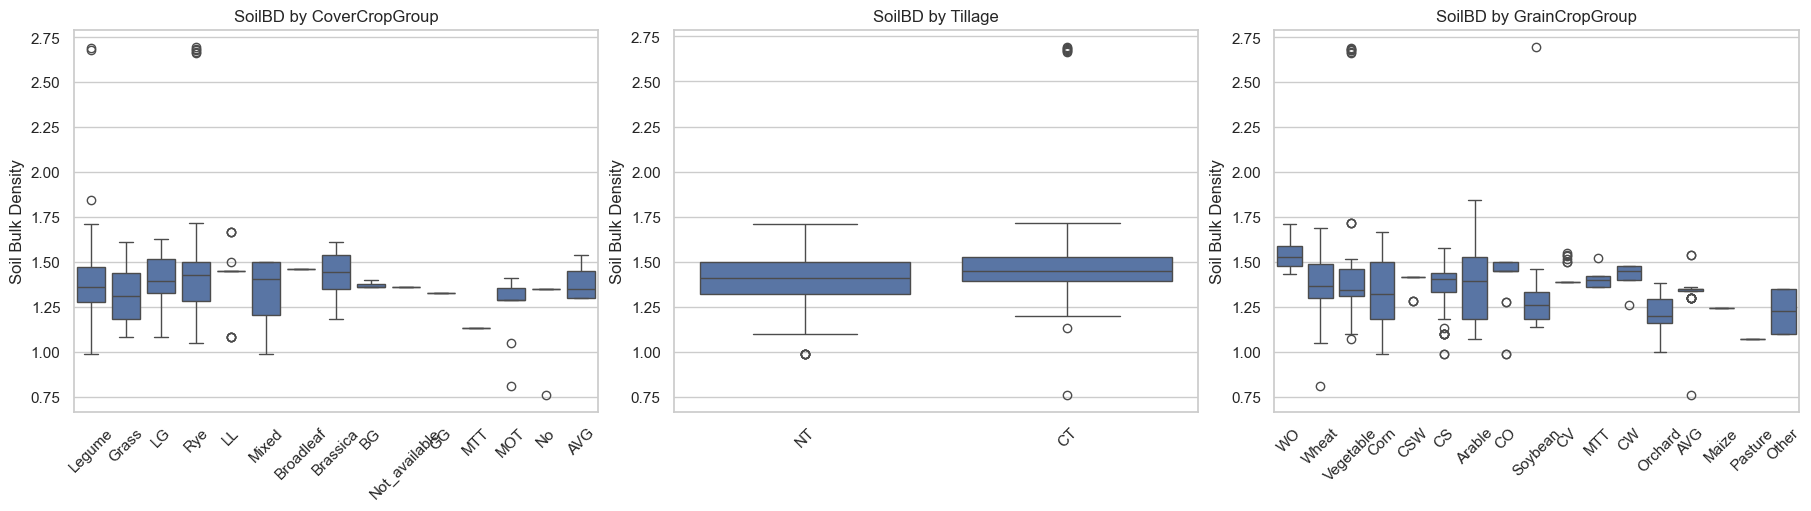

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the variables to plot (only those that are present in your DataFrame)
management_vars = ['CoverCropGroup', 'Tillage', 'GrainCropGroup']
num_vars = len(management_vars)

# Set up the figure
fig, axes = plt.subplots(nrows=1, ncols=num_vars, figsize=(6 * num_vars, 5), constrained_layout=True)

# Plot each variable
for i, var in enumerate(management_vars):
    sns.boxplot(data=df, x=var, y='SoilBD', ax=axes[i])
    axes[i].set_title(f"SoilBD by {var}")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Soil Bulk Density")

# Display the full row of plots
plt.show()


## One-way ANOVA for SoilBD across each management variable

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

anova_results = {}

for var in management_vars:
    if var in df.columns:
        temp_df = df[[var, 'SoilBD']].dropna()
        if temp_df[var].nunique() < 2:
            continue  # Skip if only 1 group
        model = ols(f"SoilBD ~ C({var})", data=temp_df).fit()
        anova_table = anova_lm(model, typ=2)
        anova_results[var] = anova_table
        print(f"\nANOVA for SoilBD by {var}:\n")
        print(anova_table)



ANOVA for SoilBD by CoverCropGroup:

                      sum_sq      df         F   PR(>F)
C(CoverCropGroup)   1.307715    14.0  2.922223  0.00021
Residual           50.184713  1570.0       NaN      NaN

ANOVA for SoilBD by Tillage:

               sum_sq     df          F        PR(>F)
C(Tillage)   1.349472    1.0  49.393287  5.046775e-12
Residual    18.824144  689.0        NaN           NaN

ANOVA for SoilBD by GrainCropGroup:

                      sum_sq      df          F        PR(>F)
C(GrainCropGroup)   5.534108    16.0  11.821218  8.789639e-30
Residual           48.804678  1668.0        NaN           NaN


## Tukey HSD Post Hoc Tests for Significant ANOVAs

In [32]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_results = {}

for var in management_vars:
    if var in df.columns:
        temp_df = df[[var, 'SoilBD']].dropna()
        if temp_df[var].nunique() < 2:
            continue
        model = ols(f"SoilBD ~ C({var})", data=temp_df).fit()
        anova_table = anova_lm(model, typ=2)
        p_value = anova_table['PR(>F)'][0]
        
        if p_value < 0.05:
            tukey = pairwise_tukeyhsd(endog=temp_df['SoilBD'],
                                      groups=temp_df[var],
                                      alpha=0.05)
            tukey_results[var] = tukey.summary()
            print(f"\nTukey HSD for {var}:\n")
            print(tukey.summary())



Tukey HSD for CoverCropGroup:

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
          AVG            BG   -0.011    1.0   -0.43 0.4081  False
          AVG      Brassica   0.0445    1.0 -0.2053 0.2943  False
          AVG     Broadleaf   0.0757 0.9999 -0.2236  0.375  False
          AVG            GG  -0.0543    1.0 -0.7035 0.5949  False
          AVG         Grass  -0.0516    1.0 -0.2842 0.1809  False
          AVG            LG   0.0071    1.0 -0.2293 0.2435  False
          AVG            LL   0.0283    1.0 -0.2367 0.2934  False
          AVG        Legume   -0.022    1.0 -0.2527 0.2086  False
          AVG           MOT  -0.1068 0.9929  -0.382 0.1684  False
          AVG           MTT  -0.2543 0.9923 -0.9035 0.3949  False
          AVG         Mixed  -0.0457    1.0 -0.3006 0.2092  False
          AVG            No  -0.1186 0.9962 

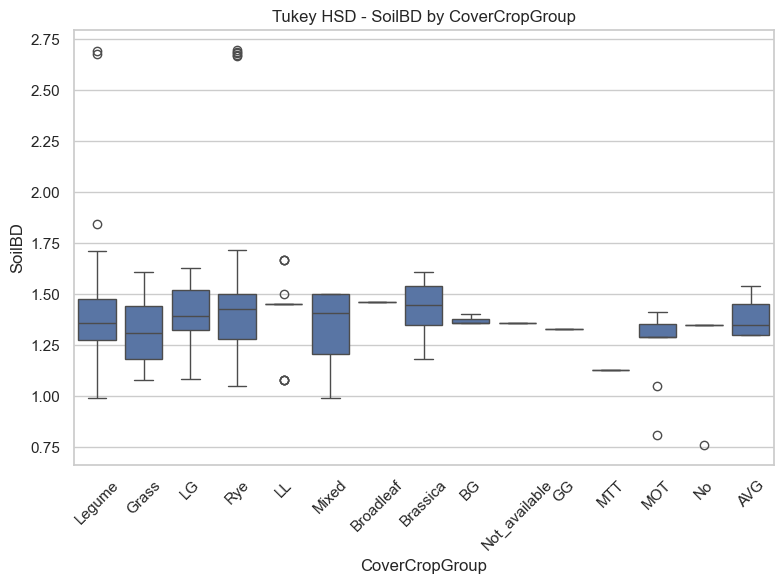

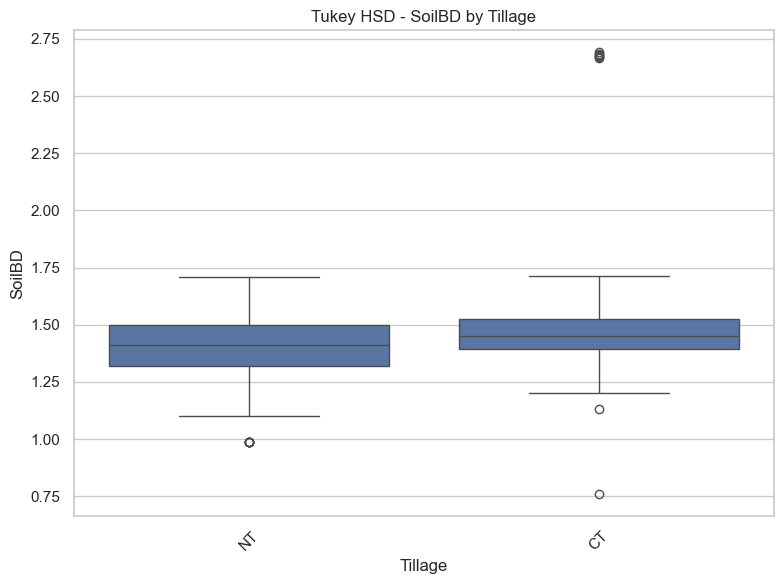

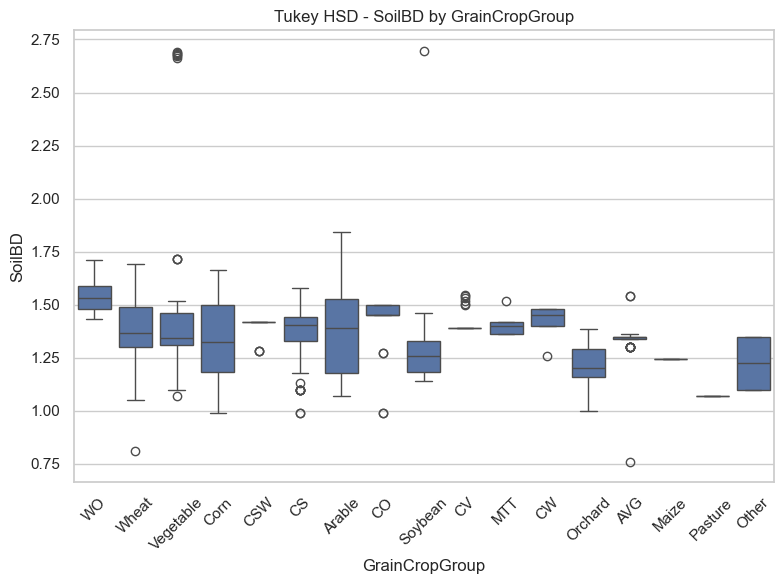

In [33]:
# Visualize
for var in tukey_results.keys():
    temp_df = df[[var, 'SoilBD']].dropna()
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=temp_df, x=var, y='SoilBD')
    plt.title(f"Tukey HSD - SoilBD by {var}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Stratified ANOVA and Boxplots by Country

In [37]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Replace this with the actual path if needed
# df = pd.read_excel("SoilHealthDB_V2.xlsx")

# Ensure 'Country' and all management_vars exist and are clean
management_vars = ['CoverCropGroup', 'Tillage', 'Rotation', 'GrainCropGroup', 'Grazing']
countries = df['Country'].dropna().unique()

results = []

for country in countries:
    df_country = df[df['Country'] == country]
    for var in management_vars:
        if var in df_country.columns:
            temp_df = df_country[['SoilBD', var]].dropna()
            if temp_df[var].nunique() < 2:
                continue  # Skip if only one category present
            try:
                model = ols(f'SoilBD ~ C({var})', data=temp_df).fit()
                anova_table = anova_lm(model, typ=2)
                f_stat = anova_table['F'][0]
                p_value = anova_table['PR(>F)'][0]
                results.append({
                    'Country': country,
                    'ManagementVariable': var,
                    'F-Statistic': round(f_stat, 2),
                    'p-Value': round(p_value, 4),
                    'Significant': 'Yes' if p_value < 0.05 else 'No'
                })
            except Exception as e:
                continue  # Skip any models that error

# Create summary table
anova_summary_table = pd.DataFrame(results)

# Display table
print(anova_summary_table)

# Optionally, export to Excel or CSV
# anova_summary_table.to_csv("anova_summary_by_country.csv", index=False)


KeyError: 'Country'